# Setup

In [1]:
cd /home/mitchellkwong/onedrive/workbins/BT4013/BT4013-toofdoctor

/home/mitchellkwong/onedrive/workbins/BT4013/BT4013-toofdoctor


In [2]:
%matplotlib inline

from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import seaborn as sns
from tqdm import tqdm

import utils

SAVE_DIR = 'models/numeric/arima'

# Models

In [26]:
class ArimaWrapper:
    def __init__(self, models={}, y=None, X=None):
        self.models = models
        self.get_y = y # Extracts y from data[future]
        self.get_X = X # Extracts X from data[future]
        
    def save(self, save_dir):
        path = Path(save_dir)
        path.mkdir(parents=True, exist_ok=True)
        for future in utils.futuresList:
            with (path / f'{future}.p').open('wb') as f:
                pickle.dump(self.models[future], f)
            
    def load(self, save_dir):
        self.models = dict()
        for future in utils.futuresList:
            with open(f'{save_dir}/{future}.p', 'rb') as f:
                self.models[future] = pickle.load(f)
    
    def fit_predict(self, data, trace=None):
        y_diff = []        
        for future in tqdm(utils.futuresList):
            if future in data:
                X = None if self.get_X is None else self.get_X(data[future])
                y = None if self.get_y is None else self.get_y(data[future])
                y_last = y.iloc[-1]
            else:
                y_diff.append(np.nan)
                continue
            
            if future in self.models:
                self.models[future].update(y_last)
            else:
                self.models[future] = pm.auto_arima(y, trace=trace)
            
            y_pred = self.models[future].predict(n_periods=1)[0]
            y_diff.append(y_pred - y_last)                
                
        return pd.Series(y_diff, index=utils.futuresList)

In [5]:
def load_ticker_data(path):
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip()
    df.index = pd.to_datetime(df['DATE'], format='%Y%m%d')
    return df

# Simulate data format in main.py
data = {
    future: load_ticker_data(f'./tickerData/{future}.txt')
    for future in utils.futuresList
}

In [29]:
wrapper = ArimaWrapper(
    y = lambda data: np.log(data['CLOSE'].tail(40)).diff(),
)

try:
    raise
    wrapper.load(SAVE_DIR)
except:
    print('No saved model! yet..')
finally:
    pred = wrapper.fit_predict(data)
#     wrapper.save(SAVE_DIR)

  3%|▎         | 3/88 [00:00<00:03, 24.56it/s]

No saved model! yet..


100%|██████████| 88/88 [00:02<00:00, 42.16it/s]


In [30]:
pred

F_AD   -0.013108
F_BO   -0.014932
F_BP   -0.002378
F_C     0.017957
F_CC   -0.035364
          ...   
F_VF    0.000757
F_VT    0.001878
F_VW    0.000088
F_GD    0.013117
F_F     0.000116
Length: 88, dtype: float64

# Walk forward optimization

In [ ]:


def walk_forward(model, train, test):
    model.fit_predict(train)
    for y in test:
        model.fit_predict(test)

In [8]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import make_pipeline



In [9]:
foo = TimeSeriesSplit(5)

In [10]:
ticker = data['F_AD']

In [13]:
?TimeSeriesSplit

In [25]:
GridSearchCV(
    estimator = ArimaWrapper(),
    param_grid = {
        'y': [
            lambda data: data['OPEN'].tail(40),
            lambda data: data['CLOSE'].tail(40),
            lambda data: data['HIGH'].tail(40),
            lambda data: data['LOW'].tail(40),
        ]
    },
    scoring = make_scorer(mean_squared_error),
    cv = TimeSeriesSplit(
        n_splits = 100,
        max_train_size = 504,
    ).split(ticker.index)
).fit(ticker, ticker)

100%|██████████| 88/88 [00:00<00:00, 549254.10it/s]


ValueError: Found input variables with inconsistent numbers of samples: [77, 88]

<AxesSubplot:>

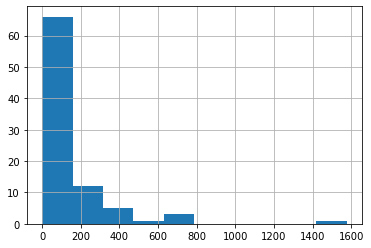

In [7]:
pred.abs().hist()